# Anomaly detection with autoencoders

Testing out variants of autoencoders for anomaly detection. We achieve this by using the autoencoders to reconstruct images of the scene, and computing the reconstruction error.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm import tqdm
from matplotlib import pyplot as plt

import numpy as np
import math

class Flow(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z):
        raise NotImplementedError("Forward pass not implemented")
    
    def inverse(self, z):
        raise NotImplementedError("Inverse pass not implemented")

/home/joel/miniconda3/envs/normflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Implement a masked affine coupling layer that operates directly on the latent vector produced by ResNet.

In [2]:
class LatentMaskedAffineCoupling(Flow):
    def __init__(self, b, net):
        super().__init__()
        self.register_buffer('b', b)
        self.net = net
        self.scaling = nn.Parameter(torch.zeros(1))

    def forward(self, z):
        z_masked = self.b * z
        s, t = self.net(z_masked).chunk(2, dim=1)

        s_exp = self.scaling.exp()
        s = torch.tanh(s / s_exp) * s_exp

        z_out = z_masked + (1 - self.b) * (z * torch.exp(s) + t)
        log_det = torch.sum((1 - self.b) * s, dim=list(range(1, self.b.dim())))
        return z_out, log_det

    def inverse(self, z):
        z_masked = self.b * z
        s, t = self.net(z_masked).chunk(2, dim=1)
        
        s_exp = self.scaling.exp()
        s = torch.tanh(s / s_exp) * s_exp

        z_out = z_masked + (1 - self.b) * (z - t) * torch.exp(-s)
        log_det = -torch.sum((1 - self.b) * s, dim=list(range(1, self.b.dim())))
        return z_out, log_det


Implement a normalising flow class that wraps around pre-specified flow layers, and allows us to do forward passes (image latent vector -> target distribution, in this case multivariate normal), as well as to sample (sample from target distribution -> image latent vector).

In [3]:
class NormalisingFlow(nn.Module):
    def __init__(self, flows, prior, device):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.prior = prior # Target distribution to be approximated
        self.device = device
        
    def forward(self, z):
        log_det = torch.zeros(z.shape, device=self.device)
        for flow in self.flows:
            z, local_log_det = flow(z)
            log_det += local_log_det
        return z, log_det

    def sample(self, sample_shape=None):
        if sample_shape:
            z = self.prior.sample(sample_shape=sample_shape)
        else:
            z = self.prior.sample() # No need to specify for multivariate normal

        z = z.to(self.device)
        for flow in reversed(self.flows):
            z, _ = flow.inverse(z)
        return z
    
    def get_prior_log_prob(self, z):
        return self.prior.log_prob(z)

Set up neural network classes needed for the flow layers

In [4]:
class MLP(nn.Module):
    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()
        if num_layers == 1:
            layers = [nn.Linear(in_size, 2*in_size)]
        else:
            layers = [nn.Linear(in_size, hidden_size, bias=True), nn.LeakyReLU()]
            for i in range(num_layers - 2):
                layers += [nn.Linear(hidden_size, hidden_size, bias=True), nn.LeakyReLU()]
            layers += [nn.Linear(hidden_size, 2*in_size, bias=True)]
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

Implements a convolutional autoencoder.

Implements building blocks like encoders and decoders, that can be use as part of a VAE or a VAE + NF.

In [5]:
class VarEncoder(nn.Module):
    def __init__(self, latent_size=64, kernel_size=5, img_height=32, channels=3):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )
        
        # Calculate the output size of the image tensor after 4 convolution layers
        out_h = img_height
        out_w = img_height
        for i in range(4):
            out_h, out_w = self.convOutputShape((out_h, out_w), kernel_size)
        
        self.flattened_size = out_h * out_w * 128
        self.latent_img_height = out_h
        
        self.fc_mu = nn.Sequential(
            nn.Linear(self.flattened_size, latent_size, bias=True)
        )
        
        self.fc_sigma = nn.Sequential(
            nn.Linear(self.flattened_size, latent_size, bias=True)
        )
        
    def forward(self, x):
        z = self.conv(x).view(x.shape[0], -1)
        mu = self.fc_mu(z)
        sigma = torch.exp(self.fc_sigma(z)) + 1e-7
        return mu, sigma
    
    def convOutputShape(self, h_w, kernel_size=1, stride=1, pad=0, dilation=1):
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        h = math.floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
        w = math.floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
        return h, w
    
class VarDecoder(nn.Module):
    def __init__(self, flattened_size, latent_img_height, latent_size=64, kernel_size=5, channels=3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_size, flattened_size)
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, channels, kernel_size)
        )
        self.latent_img_height = latent_img_height
        
        
    def forward(self, x):
        z = self.fc(x).view(x.shape[0], 128, self.latent_img_height, self.latent_img_height)
        im = self.conv(z)
        return im

Set up classes that put the previous components together into the form of a VAE, and VAE + NF.

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, device, flows = None, latent_size=64, kernel_size=5, img_height=32, channels=3):
        super().__init__()
        self.encoder = VarEncoder(latent_size, kernel_size, img_height, channels)
        self.decoder = VarDecoder(self.encoder.flattened_size, self.encoder.latent_img_height)
        self.device = device
        self.flows = flows
        self.latent_size = latent_size
        
    def forward(self, x):
        mu, sigma = self.encoder(x)
        z0 = self.reparameterize(mu, sigma)
        
        if self.flows is None:
            zk = z0
            var_loss = -0.5 * torch.sum(1 + torch.log(sigma) - mu.pow(2) - sigma)
        else:
            log_pi = torch.log(torch.tensor(2 * np.pi))
            log_sigma = torch.log(sigma)
            
            assert(not torch.any(torch.isnan(log_sigma)))
            assert(not torch.any(torch.isnan(z0)))
            assert(not torch.any(torch.isnan(mu)))
            
            log_prob_z0 = torch.sum(
                -0.5 * log_pi - log_sigma - 0.5 * ((z0 - mu) / sigma) ** 2, 
                axis=1)
            
            zk, log_det = self.flows(z0)
            log_prob_zk = torch.sum(-0.5 * log_pi - 0.5 * (zk**2), axis=1)
            
            var_loss = torch.mean(log_prob_z0) - torch.mean(log_prob_zk) - torch.mean(log_det)
            
        im = self.decoder(zk)
        return im, mu, sigma, var_loss
    
    def reparameterize(self, mu, sigma):
        epsilon = torch.randn_like(mu, device=self.device)
        z = mu + sigma * epsilon
        return z
    
    def sample(self, batch_size):
        # Sample from N(0, 1)
        z = torch.randn((batch_size, self.latent_size), device=self.device)
        if self.flows is not None:
            z, _ = self.flows(z)
        im = self.decoder(z)
        return im

## Tests

Load the datasets.

In [7]:
batch_size = 64

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor()])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = datasets.CIFAR10(root="../../nf_tutorial/data", train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [42000, 8000])

# Loading the test set
test_set = datasets.CIFAR10(root="../../nf_tutorial/data", train=False, transform=transform, download=True)

# Define the data loaders. We currently do not use the validation and test sets.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

print("Loaded in data.")

Files already downloaded and verified
Files already downloaded and verified
Loaded in data.


### Convolutional autoencoders

### Variational autoencoders

Set up the models, hyperparameters and loss function.

In [9]:
n_epochs = 20

enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [10]:
def recon_loss(x, y):
    return torch.sum((x - y)**2)

Instantiate a VAE.

In [11]:
vae = VariationalAutoencoder(device).to(device)

Training the VAE.

In [12]:
optimizer =  torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-4)
for epoch in range(n_epochs):
    progressbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        optimizer.zero_grad()
        outputs, mu, sigma, var_loss = vae(x)
        #loss = elbo_loss(x.detach(), outputs.detach(), mu.detach(), sigma.detach())
        #loss = elbo_loss(x, outputs, mu, sigma)
        loss = recon_loss(x, outputs) + var_loss
        loss.backward()
        optimizer.step()
        progressbar.update()
    progressbar.close()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_n * len(x), len(train_loader.dataset),
                       100. * batch_n / len(train_loader),
                       loss.item()))
    
torch.save(vae.state_dict(), "../../nf_tutorial/saved_models/vae.ckpt")

100%|██████████| 657/657 [00:21<00:00, 29.92it/s]


Train Epoch: 0 [10496/42000 (100%)]	Loss: 2854.261230


100%|██████████| 657/657 [00:21<00:00, 30.92it/s]


Train Epoch: 1 [10496/42000 (100%)]	Loss: 2127.136719


100%|██████████| 657/657 [00:22<00:00, 28.97it/s]


Train Epoch: 2 [10496/42000 (100%)]	Loss: 1765.260986


100%|██████████| 657/657 [00:22<00:00, 28.95it/s]


Train Epoch: 3 [10496/42000 (100%)]	Loss: 1855.467163


100%|██████████| 657/657 [00:22<00:00, 28.96it/s]


Train Epoch: 4 [10496/42000 (100%)]	Loss: 1512.235107


100%|██████████| 657/657 [00:21<00:00, 30.42it/s]


Train Epoch: 5 [10496/42000 (100%)]	Loss: 1471.182251


100%|██████████| 657/657 [00:20<00:00, 31.33it/s]


Train Epoch: 6 [10496/42000 (100%)]	Loss: 1377.500244


100%|██████████| 657/657 [00:20<00:00, 31.47it/s]


Train Epoch: 7 [10496/42000 (100%)]	Loss: 1318.766602


100%|██████████| 657/657 [00:20<00:00, 31.42it/s]


Train Epoch: 8 [10496/42000 (100%)]	Loss: 1299.241821


100%|██████████| 657/657 [00:22<00:00, 28.93it/s]


Train Epoch: 9 [10496/42000 (100%)]	Loss: 1214.291382


100%|██████████| 657/657 [00:22<00:00, 28.89it/s]


Train Epoch: 10 [10496/42000 (100%)]	Loss: 1224.226929


100%|██████████| 657/657 [00:22<00:00, 28.88it/s]


Train Epoch: 11 [10496/42000 (100%)]	Loss: 1188.414673


100%|██████████| 657/657 [00:22<00:00, 28.84it/s]


Train Epoch: 12 [10496/42000 (100%)]	Loss: 1186.459717


100%|██████████| 657/657 [00:22<00:00, 28.85it/s]


Train Epoch: 13 [10496/42000 (100%)]	Loss: 1147.807251


100%|██████████| 657/657 [00:22<00:00, 28.83it/s]


Train Epoch: 14 [10496/42000 (100%)]	Loss: 1135.616577


100%|██████████| 657/657 [00:22<00:00, 28.84it/s]


Train Epoch: 15 [10496/42000 (100%)]	Loss: 1142.939941


100%|██████████| 657/657 [00:22<00:00, 28.85it/s]


Train Epoch: 16 [10496/42000 (100%)]	Loss: 1126.245239


100%|██████████| 657/657 [00:22<00:00, 28.83it/s]


Train Epoch: 17 [10496/42000 (100%)]	Loss: 1105.225098


100%|██████████| 657/657 [00:22<00:00, 28.80it/s]


Train Epoch: 18 [10496/42000 (100%)]	Loss: 1101.928711


100%|██████████| 657/657 [00:22<00:00, 28.91it/s]


Train Epoch: 19 [10496/42000 (100%)]	Loss: 1081.996094


Sampling from the trained normalising flow.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


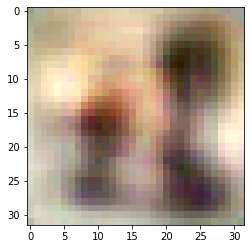

In [13]:
samples = vae.sample(2)
ims = samples.to('cpu').detach().numpy()
im0 = ims[0].swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(im0)
plt.show()

Test against a clean VAE that has not been trained.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


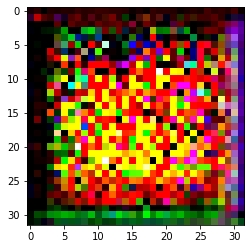

In [14]:
vae_clean = VariationalAutoencoder(device).to(device)
samples = vae_clean.sample(2)
ims = samples.to('cpu').detach().numpy()
im0 = ims[0].swapaxes(0, 2).swapaxes(0, 1)

plt.imshow(im0)
plt.show()

### Variational autoencoders with normalising flows

Set up the hyperparameters, and construct the flow.

In [74]:
n_epochs = 20
n_bottleneck = 64
n_flows = 8

enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

# Specify the flow layers
b = torch.tensor(n_bottleneck // 2 * [0, 1] + n_bottleneck % 2 * [0])
flows = []
for i in range(n_flows):
    st_net = MLP(n_bottleneck, 1024, 3)
    if i % 2 == 0:
        flows += [LatentMaskedAffineCoupling(b, st_net)]
    else:
        flows += [LatentMaskedAffineCoupling(1 - b, st_net)]

# Specify the prior (target distribution)
# prior = torch.distributions.MultivariateNormal(
#     torch.zeros(n_bottleneck, device=device),
#     torch.eye(n_bottleneck, device=device)
#     )
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        
# Construct the normalising flow
nf = NormalisingFlow(flows, prior, device).to(device)

In [75]:
def recon_loss(x, y):
    return torch.sum((x - y)**2)

Instantiate a VAE with normalising flow.

In [76]:
vae_nf = VariationalAutoencoder(device, flows=nf, latent_size=n_bottleneck).to(device)

Train the VAE-NF.

In [78]:
optimizer =  torch.optim.Adam(vae_nf.parameters(), lr=1e-4, weight_decay=1e-4)
for epoch in range(n_epochs):
    progressbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_n, (x, n) in progressbar:
        x = x.to(device)
        optimizer.zero_grad()
        outputs, mu, sigma, var_loss = vae_nf(x)
        loss = var_loss + recon_loss(x, outputs)
        loss.backward()
        optimizer.step()
        progressbar.update()
    progressbar.close()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_n * len(x), len(train_loader.dataset),
                       100. * batch_n / len(train_loader),
                       loss.item()))
    
torch.save(vae_nf.state_dict(), "../../nf_tutorial/saved_models/vae_nf.ckpt")

100%|██████████| 657/657 [00:28<00:00, 23.43it/s]


Train Epoch: 0 [10496/42000 (100%)]	Loss: 868.067993


100%|██████████| 657/657 [00:27<00:00, 23.58it/s]


Train Epoch: 1 [10496/42000 (100%)]	Loss: -21.193848


100%|██████████| 657/657 [00:27<00:00, 23.56it/s]


Train Epoch: 2 [10496/42000 (100%)]	Loss: -779.310303


100%|██████████| 657/657 [00:28<00:00, 23.43it/s]


Train Epoch: 3 [10496/42000 (100%)]	Loss: -1062.648193


100%|██████████| 657/657 [00:28<00:00, 23.24it/s]


Train Epoch: 4 [10496/42000 (100%)]	Loss: -1273.984131


100%|██████████| 657/657 [00:27<00:00, 23.54it/s]


Train Epoch: 5 [10496/42000 (100%)]	Loss: -1320.980713


100%|██████████| 657/657 [00:27<00:00, 23.54it/s]


Train Epoch: 6 [10496/42000 (100%)]	Loss: -1558.102295


100%|██████████| 657/657 [00:28<00:00, 23.43it/s]


Train Epoch: 7 [10496/42000 (100%)]	Loss: -1695.651367


100%|██████████| 657/657 [00:27<00:00, 23.54it/s]


Train Epoch: 8 [10496/42000 (100%)]	Loss: -1766.254395


100%|██████████| 657/657 [00:27<00:00, 23.53it/s]


Train Epoch: 9 [10496/42000 (100%)]	Loss: -2030.025146


100%|██████████| 657/657 [00:27<00:00, 23.52it/s]


Train Epoch: 10 [10496/42000 (100%)]	Loss: -1923.723755


100%|██████████| 657/657 [00:28<00:00, 23.39it/s]


Train Epoch: 11 [10496/42000 (100%)]	Loss: -2214.815430


100%|██████████| 657/657 [00:27<00:00, 23.66it/s]


Train Epoch: 12 [10496/42000 (100%)]	Loss: -2304.502441


100%|██████████| 657/657 [00:28<00:00, 23.26it/s]


Train Epoch: 13 [10496/42000 (100%)]	Loss: -2350.472168


100%|██████████| 657/657 [00:27<00:00, 23.60it/s]


Train Epoch: 14 [10496/42000 (100%)]	Loss: 1817499.250000


100%|██████████| 657/657 [00:27<00:00, 23.51it/s]


Train Epoch: 15 [10496/42000 (100%)]	Loss: 7039.498535


100%|██████████| 657/657 [00:28<00:00, 22.72it/s]


Train Epoch: 16 [10496/42000 (100%)]	Loss: 9265.075195


100%|██████████| 657/657 [00:27<00:00, 23.57it/s]


Train Epoch: 17 [10496/42000 (100%)]	Loss: 14461.925781


100%|██████████| 657/657 [00:27<00:00, 23.54it/s]


Train Epoch: 18 [10496/42000 (100%)]	Loss: 8925.414062


100%|██████████| 657/657 [00:27<00:00, 23.57it/s]


Train Epoch: 19 [10496/42000 (100%)]	Loss: 10051.555664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


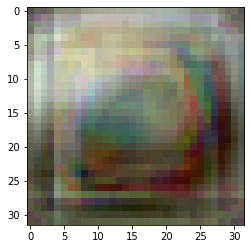

In [87]:
samples = vae_nf.sample(2)
ims = samples.to('cpu').detach().numpy()
im0 = ims[0].swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(im0)
plt.show()